# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт

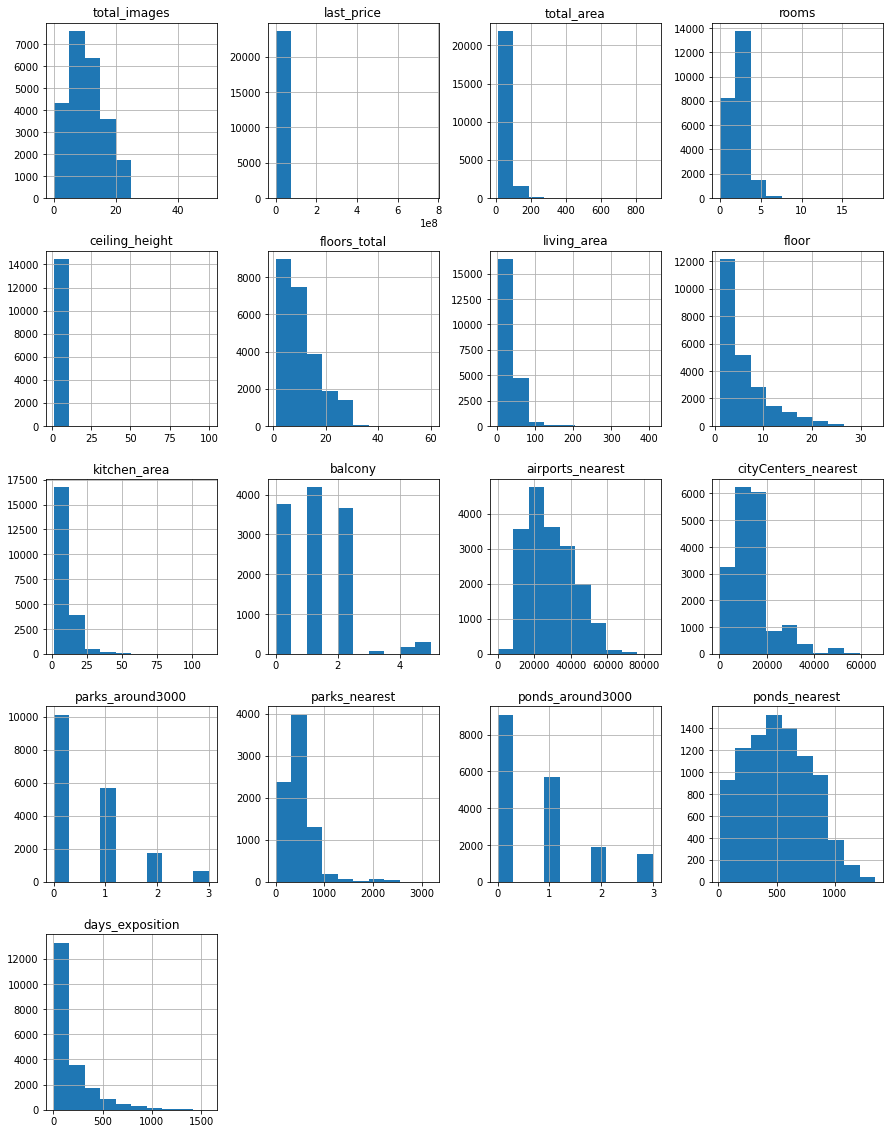

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
print(data.head(5))
data.info()

data.hist(figsize=(15,20))
plt.show()

Изучив гистограммы можно сделать выводы, что большую часть составляют данные:
  1. Общее количество фотографий 10-15
  2. Последняя цена в данной гистограмме плохо видна, используем метод describe(), и увидем, что большая часть это от 5-7 млн.
  3. Общая площадь до 100 м2
  4. Комнаты - 3
  5. Высота потолка - менее 10 м
  6. Количество этажей - 5
  7. Жилая площадь - до 50 м2
  8. Этаж - не выше 5
  9. Площадь кухни - до 15 м2
  10. Балкон, много нулевых значений из-за пропусков
  11. Расстояние до аэропорта - 20 000 м
  12. Расстояние до центра - 10 000- 20 000 м
  13. Парк в 3 км - много нулевых значений из-за пропусков
  14. Ближайший парк - 500 м
  15. Водоём в 3км - много нулевых значений из-за пропусков
  16. Ближайший водоём - 500 м
  17. Дни размещения - до 100 дней

In [3]:
data['last_price'].describe().apply(lambda x: format(x, 'f'))

count        23699.000000
mean       6541548.771552
std       10887013.267545
min          12190.000000
25%        3400000.000000
50%        4650000.000000
75%        6800000.000000
max      763000000.000000
Name: last_price, dtype: object

### Предобработка данных

Вывод: Ознакомившись с данными датафрейма можно увидеть, что присутствуют пропуски в 13 столбцах.

Причины их появления могут быть следующие:
  - 5. Высота потолков. Пропуски 38%, скорее всего многие продавцы не обращаются к документации на жилье для уточнения данной информации, так как считают данный фактор не показательным для расчета стоимости. Заполним пропуски медианным значением.
  - 6. Всего этажей в доме. Пропуски менее 1%, возможно на продаже дома либо продавец проигнорировал заполнение данной строки, пропуски заполним медианным значением.
  - 7. Жилая площадь. Пропуски 8%, небольшой показатель, но тем не менее один из самых важных для формирования стоимости. Заменим пропуски медианным значением.
  - 9. Апартаменты. Пропуски 88%, слишком много пропусков, необходимо передать информацию разработчикам, возможно ошибка при сборе данных. Заменим пропуски на no_information
  - 12. Площадь кухни. Пропуски 9%, так как на продаже есть студии - площадь кухни вписали в общую жилую площадь, по этому данные пропуски можно заменить на 0, если это не студия, то пропуски можно заменить на медианное значение.
  - 13. Балкон. Пропуски 48%, могут означать, что в квартире нет балкона, по этому NaN заменим на 0.
  - 14. Название населённого пункта. Пропуски менее чем 1%, можем их заменить на 'unkwown'
  - Пропуски с 15 по 20 столбец можно объяснить тем, что данные получены по всей территории Ленобласти, и в мелких населенных пунктах нет аэропорта, парка, центра и водоемов. По этому пока пропуски оставляем как есть.
  - Пропуски в столбце 21 можно объяснить тем, что некоторые объекты находятся еще на продаже, по этому заполним их средним значением

Также для анализа необходимо изменить типы данных для некоторых столбцов:

  - first_day_exposition, изменим тип с object на data, так как все данные указаны в виде даты размещения объекта;
  - floors_total, изменим тип с float64 на int64, так как общее количество этажей может быть только целым числом;
  - balcony, изменим тип с float64 на int64, так как количество балконов может быть только целое число;
  - days_exposition, изменим тип с float64 на int64, так как количество дней измеряется целыми числами.
  
Приведём наименование столбцов к змеиному типу, а также изучим данные перед заполнением пропусков.

In [4]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest', 'parks_around3000':'parks_around_3000', 'ponds_around3000':'ponds_around_3000'})

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')


In [5]:
print(data['ceiling_height'].unique())

#здесь мы видим аномалии в виде чисел больше 10. При некорректном заполнении, десятичные цифры были перенесены в целое число
#что привело к нереальным числам: 14, 22, 32 метра и т.д. Необходимо это исправить.

data.loc[data['ceiling_height'] >= 10, 'ceiling_height'] /=10

#заполняем пропуски медианным значением и проверяем заполнение через info

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data.info()

[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8    4.5    4.2    3.36  32.     3.08   3.68   3.07   3.37
   3.09   8.     3.26   3.34   2.81   3.44   2.97   3.14   4.37   2.68
   3.22   3.27  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63
   3.32  26.     1.2    8.3    2.98   2.86   3.17   4.4    3.28   3.04
   4.45   5

In [6]:
print(data['floors_total'].unique())


[16. 11.  5. 14. 12. 26. 24. 27.  9.  6. 17. 25.  3. 23. 19. 18.  4. 22.
  8.  2. 10.  7. 13. 15. nan 20. 28. 36. 21. 35. 34. 60.  1. 29. 33. 52.
 37.]


In [7]:
data['living_area'].describe()
#сразу видно, что в данных есть аномалии, такие как жилая площадь менее 10 м2
#их обработаем в 4 пункте, сейчас заполним пропуски медианным значением и вызовем info


count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [8]:
#заполним пропуски в жилой площади медианным значением, согласно категоризации по количеству комнат
for x in data['rooms'].unique():
    data.loc[(data['rooms'] == x) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == x), 'living_area'].median()

In [9]:
#проверяем пропуски в столбце
data['living_area'].isna().sum()

0

In [10]:
print(data['is_apartment'].value_counts())
#всего 2775 заполненных строк, всё остальное пропуски. Данную информацию мы не можем восстановить
#по этому для удобства заполним пропуски на no_information и оставим тип данных как object
data['is_apartment'] = data['is_apartment'].fillna('no_information')
data.info()

False    2725
True       50
Name: is_apartment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area 

In [11]:
#отфильтруем таблицу и проверим есть ли студии в пропусках по столбцу "площадь кухни"
print(data[(data['kitchen_area'].isnull()) & (data['studio'] == True)])

#данные пропуски мы можем заменить на 0, так как эти объекты являются студиями и площадь кухни входит в общую площадь
data.loc[(data['kitchen_area'].isnull()) & (data['studio'] == True), 'kitchen_area'] = 0

#проверяем заполнение вызвав еще раз отфильтрованную таблицу по условию
print(data[(data['kitchen_area'].isnull()) & (data['studio'] == True)])

#так как остальные объекты не являются студиями, оставшиеся пропуски заполним медианным значением
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

data.info()

       total_images  last_price  total_area first_day_exposition  rooms  \
144               1   2450000.0       27.00           2017-03-30      0   
440               8   2480000.0       27.11           2018-03-12      0   
608               2   1850000.0       25.00           2019-02-20      0   
697              12   2500000.0       24.10           2017-12-01      0   
716               5   1500000.0       17.00           2017-06-07      0   
...             ...         ...         ...                  ...    ...   
22867             8   3090000.0       30.00           2017-12-17      0   
22877             2   4280000.0       28.00           2017-10-26      0   
23210             7   3200000.0       26.00           2017-09-01      0   
23554            15   3350000.0       26.00           2018-09-07      0   
23637             8   2350000.0       26.00           2018-06-26      0   

       ceiling_height  floors_total  living_area  floor    is_apartment  \
144              2.65   

In [95]:
#заполним пропуски в столбце balcony и изменим тип данных на int, проверим через метод info
data['balcony'] = (data['balcony']
                   .fillna(0)
                   .astype('int')
                  )
#заполним пропуски в столбце locality_name на 'uknown' и проверим через info
data['locality_name'] = data['locality_name'].fillna('uknown')

#столбцы с 15 по 20 оставляем с пропусками

#оставляем пропуски в столбце days_exposition

print(data['balcony'].isna().sum())
print(data['locality_name'].isna().sum())


0
0


In [13]:
#изучим данные в столбце locality_name и избавимся от дубликатов

print(data['locality_name'].unique())
print()
print(data['locality_name'].nunique())

#365 уникальных значений, первое, что попадается на галаза - это написание слова "посёлок" через е и ё
data['locality_name'] = data['locality_name'].replace(['поселок'], 'посёлок', regex=True)
print(data['locality_name'].nunique())

#уникальных значений стало 331

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

### Промежуточный вывод:

1. Заполнили пропуска в столбцах: 5,7,9,12,13,14.
2. Изменили типы данных для дальнейшего анализа.
3. Как видим в столбцах с 15 по 20 автоматизированная система собирает данные не для всех населенных пунктов, по этому пропуски в данных столбцах мы не можем заменить.

### Посчитайте и добавьте в таблицу новые столбцы

In [14]:
#добавляем в таблицу столбец "цена 1 м2"
data['m2_price'] = (data['last_price'] / data['total_area']).round(2)

#добавляем столбцы: день недели, месяц и год публикации, импортируем библиотеку datetime

data['exposition_day'] = data['first_day_exposition'].dt.weekday
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year

#добавляем столбец "тип этажа квартиры" 
def floor_type(data):
    if data['floor'] == 1:
        return 'первый'
    elif data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

#добавляем столбец "расстояние до центра города в км"
data['city_centers_km'] = (data['city_centers_nearest'] / 1000).round()

print(data.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor    is_apartment  studio  \
0            2.70          16.0         51.0      8  no_information   False   
1            2.65          11.0         18.6      1  no_information   False   
2            2.65           5.0         34.3      4  no_information   False   
3            2.65          14.0         45.0      9  no_information   False   
4            3.03          14.0         32.0     13  no_information   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False         25.

### Промежуточный вывод:

Посчитали цену за м2 для дальнейшего анализа.

### 3. Исследовательский анализ данных

1. Изучим отдельные столбцы, построим для каждого гистограмму и определим аномалии.

In [15]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Стандартное отклонение от среднего значения 35.65 м2 весьма велико, а также максимальное значение в 900 м2 является поводом для детального изучения данных.

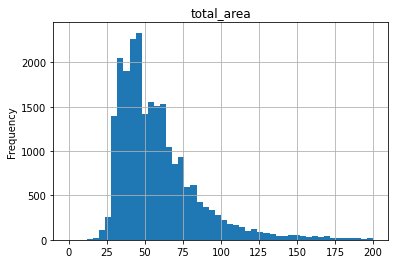

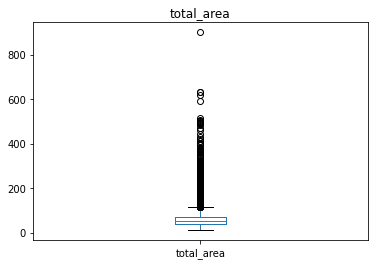

In [16]:
data['total_area'].plot(kind='hist', bins=50, range=(0,200), grid=True,title='total_area')
plt.show()
data['total_area'].plot(kind='box', title='total_area')
plt.show()

Видим выбросы с отметки где-то 150, по этому изменим масштаб чтобы лучше увидеть. Также выведем на экран выбросы более 500, чтобы проверить возможность корректировки.

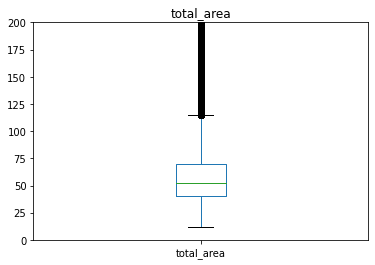

In [17]:
data['total_area'].plot(kind='box', title='total_area')
plt.ylim(0, 200)
plt.show()


In [18]:
print(data.query('total_area >= 500'))

       total_images   last_price  total_area first_day_exposition  rooms  \
3117             19  140000000.0       631.0           2019-03-30      7   
4237              1   50000000.0       517.0           2017-10-14      7   
5358             20   65000000.0       590.0           2019-02-14     15   
5893              3  230000000.0       500.0           2017-05-31      6   
8018             20   84000000.0       507.0           2015-12-17      5   
12859            20  140000000.0       631.2           2019-04-09      7   
15016             8  150000000.0       500.0           2016-01-13      4   
15651            20  300000000.0       618.0           2017-12-18      7   
19540             8  420000000.0       900.0           2017-12-06     12   

       ceiling_height  floors_total  living_area  floor    is_apartment  \
3117             2.65           5.0        145.0      5  no_information   
4237             2.65           4.0        332.0      3  no_information   
5358          

Судя по количеству комнат и стоимости объекта - это не ошибка при вводе данных, а всё-таки продажа объектов. Их всего 9 штук удалим из датафрейма  и проверим как изменились данные с помощью describe

In [19]:
data = data.query('total_area < 500')

data['total_area'].describe()

count    23690.000000
mean        60.143878
std         33.998196
min         12.000000
25%         40.000000
50%         52.000000
75%         69.787500
max        495.000000
Name: total_area, dtype: float64

Стандартное отклонение изменилось с 35 на 33 м2. Проверим теперь сколько процентов составляют выбросы, где площадь квартиры более 200 м2.

In [20]:
print(len(data.query('total_area >=120')) / len(data))  

0.045968763191219925


Менее 3.5% составляют квартиры с метражем от 120 м2, по этому удаляем данные выбросы из датафрейма.

In [62]:
data = data.query('total_area < 120')
data['total_area'].describe()

count    22601.000000
mean        54.757439
std         19.945249
min         12.000000
25%         39.500000
50%         50.400000
75%         66.000000
max        119.800000
Name: total_area, dtype: float64

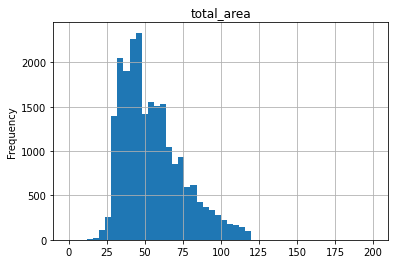

In [63]:
data['total_area'].plot(kind='hist', bins=50, range=(0,200), grid=True, title='total_area')
plt.show()

Теперь стандартное отклонение составляет 20.04 м2, а среднее значение 54.86 м2.

Проверим аналогично столбец "жилая площадь".

In [64]:
data['living_area'].describe()

count    22601.000000
mean        31.245061
std         13.777483
min          2.000000
25%         18.000000
50%         30.000000
75%         40.500000
max        145.000000
Name: living_area, dtype: float64

Жилая площадь - 2 м2, такого точно не может быть, такие аномалии нужно удалить, сначала построим гистограммы и выведем площади менее 10 м2.

In [24]:
print(data.query('living_area <= 10'))



       total_images  last_price  total_area first_day_exposition  rooms  \
114               5   4000000.0       21.40           2019-02-07      1   
248               7   4100000.0       31.00           2015-08-02      1   
615              15   4100000.0       43.00           2017-06-30      1   
680              14   7200000.0       43.00           2017-10-31      1   
1326              8   8100000.0       52.00           2017-01-29      2   
1816              3   1650000.0       22.00           2016-09-19      1   
1947             11   1400000.0       24.00           2018-06-15      1   
2309             10   4200000.0       62.40           2017-06-15      2   
2654              4   3936700.0       42.80           2018-01-02      1   
2699             14   3850000.0       37.10           2017-10-24      1   
3242              7   4440000.0       41.00           2017-07-02      1   
4100             17   5300000.0       34.80           2017-06-19      1   
4542             12   330

Данные столбца "жилая площадь" не соответствуют действительности, т.к. при общей площади 52 м2 - жилая площадь не может составлять всего 2 м2, медианным и средним значением заменять нельзя, так как оно больше чем общая площадь некоторых объектов.


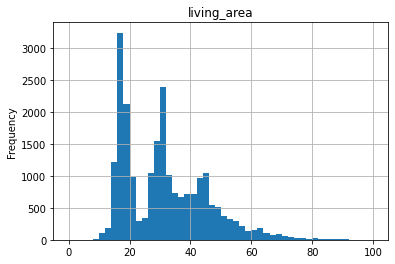

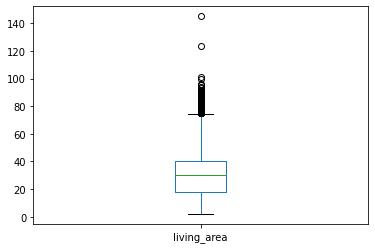

In [25]:
data['living_area'].plot(kind='hist', bins=50, range=(0,100), grid=True, title='living_area')
plt.show()
data['living_area'].plot(kind='box')
plt.show()

In [67]:
print(len(data.query('living_area <=10')) / len(data)) 

#удалим данные строки, а также, которые более 100 м2 также удалим, так как максимальный метраж общей площади 120 м2.
data = data.query('living_area > 10 and living_area <= 100')


0.0



Проведём анализ для столбца "площадь кухни".

In [68]:
data['kitchen_area'].describe()

count    22541.000000
mean         9.783903
std          4.364636
min          0.000000
25%          7.000000
50%          9.010000
75%         11.000000
max         64.000000
Name: kitchen_area, dtype: float64

In [28]:
#Проверяем являются ли большие площади кухни студиями
print(data[(data['kitchen_area'] >=50) & (data['studio'] == True)])


Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around_3000, parks_nearest, ponds_around_3000, ponds_nearest, days_exposition, m2_price, exposition_day, exposition_month, exposition_year, floor_type, city_centers_km]
Index: []


Как видим, что данные кухни не являются студиями и занимают практически половину или всю площадь объекта. Проверим какой процент составляют данные площади.

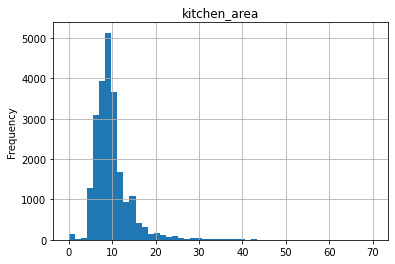

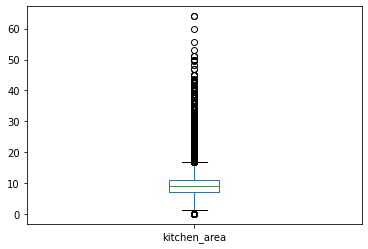

In [29]:
data['kitchen_area'].plot(kind='hist', bins=50, range=(0,70), grid=True, title='kitchen_area')
plt.show()
data['kitchen_area'].plot(kind='box')
plt.show()

Кухни с площадью 0 м2 мы отбрасывать не будем, так как это студии.
А вот площади свыше 30 м2 кажутся очень странными, при том, что максимальная площадь объекта составляет 120 м2.
Посмотрим на эти данные.

In [69]:
print(data.query('kitchen_area >=30'))
print(len(data.query('kitchen_area >=30')) / len(data))  

       total_images  last_price  total_area first_day_exposition  rooms  \
4                 2  10000000.0       100.0           2018-06-19      2   
239              16  22000000.0       119.0           2017-02-16      3   
379              14  21000000.0        96.0           2017-02-07      2   
511               7   5950000.0        69.0           2017-12-21      1   
576              12   8600000.0       100.0           2017-09-11      3   
...             ...         ...         ...                  ...    ...   
21989            12  13500000.0       109.0           2016-05-08      3   
22016             1  13500000.0        95.0           2019-03-18      3   
22134             7   8353000.0        77.0           2017-10-09      4   
22948            10  34500000.0       100.0           2018-06-26      3   
23134             4  12900000.0       118.0           2016-01-20      3   

       ceiling_height  floors_total  living_area  floor    is_apartment  \
4                3.03   

Менее 1 %, можем удалить данные выбросы.

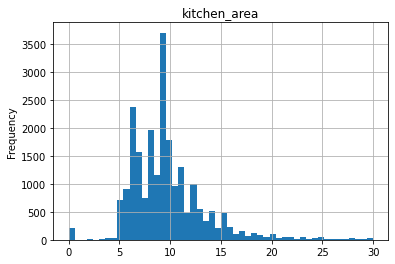

In [72]:
data = data.query('kitchen_area <= 30')
data['kitchen_area'].plot(kind='hist', bins=50, range=(0,30), grid=True, title='kitchen_area')
plt.show()

Теперь проанализируем столбец "количество комнат".

In [73]:
data['rooms'].describe()

count    22405.000000
mean         1.957108
std          0.906585
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

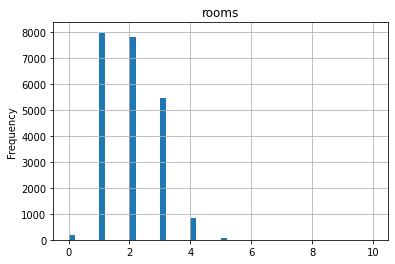

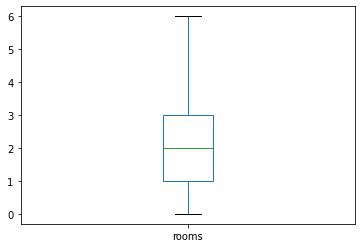

In [74]:
data['rooms'].plot(kind='hist', bins=50, range=(0,10), grid=True, title='rooms')
plt.show()
data['rooms'].plot(kind='box')
plt.show()

Объекты без комнат являются студиями, если это будет верно, тогда нулевые значения оставляем, если нет - заменяем нули на медианное значение. Но для начала удалим аномалии, выше 6.

In [76]:
data = data.query('rooms < 6')
data['rooms'].describe()

count    22397.000000
mean         1.955664
std          0.903521
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

In [77]:
#проверяем есть ли среди объектов без комнат не студии
print(data[(data['rooms'] == 0) & (data['studio'] == False)])


Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around_3000, parks_nearest, ponds_around_3000, ponds_nearest, days_exposition, m2_price, exposition_day, exposition_month, exposition_year, floor_type, city_centers_km]
Index: []


Так как это открытая планировка, то объект является студией, по этому в этих данных нужно изменить значения в столбце studio на True, а в столбце kitchen_area убрать медианное значение.

In [78]:
data.loc[(data['rooms'] == 0) & (data['studio'] == False), 'kitchen_area'] = 0
data.loc[(data['rooms'] == 0) & (data['studio'] == False), 'studio'] = True

#проверяем выполнение кода
print(data[(data['rooms'] == 0) & (data['studio'] == False)])

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around_3000, parks_nearest, ponds_around_3000, ponds_nearest, days_exposition, m2_price, exposition_day, exposition_month, exposition_year, floor_type, city_centers_km]
Index: []


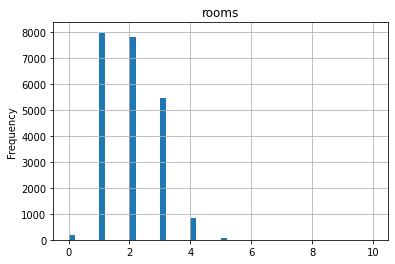

In [79]:
data['rooms'].plot(kind='hist', bins=50, range=(0,10), grid=True, title='rooms')
plt.show()

Проведем анализ в столбце "высота потолков", ранее аномалии были исправлены, проверим на гистограмме.

In [80]:
data['ceiling_height'].describe()

count    22397.00000
mean         2.68131
std          0.21255
min          1.00000
25%          2.60000
50%          2.65000
75%          2.70000
max         10.00000
Name: ceiling_height, dtype: float64

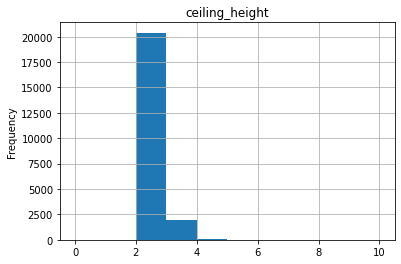

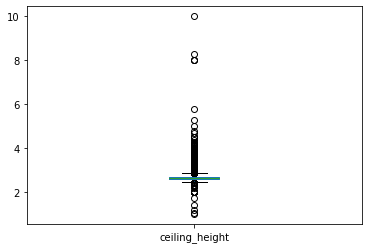

In [82]:
data['ceiling_height'].plot(kind='hist', bins=10, range=(0,10), grid=True, title='ceiling_height')
plt.show()
data['ceiling_height'].plot(kind='box')
plt.show()

Высота потолков менее 2.4 метра является ниже стандарта по которым ранее строили "хрущёвки", в новостройках высота потолков составляет от 2.5 метров. По этому всё, что меньше 2.4 метра можно удалить из данных. Посчитаем процент потолков, высота которых составляет более 4.2 метров.

In [83]:
data = data.query('ceiling_height >= 2.4')
print(len(data.query('ceiling_height >= 4.2')) / len(data))  

0.001072769533345253


Менее 1%, можем удалить их из датафрейма.

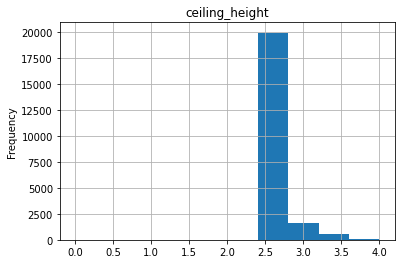

In [86]:
data = data.query('ceiling_height <= 4.2')
data['ceiling_height'].plot(kind='hist', bins=10, range=(0,4), grid=True, title='ceiling_height')
plt.show()

Построим гистрограмму для типа этажей.

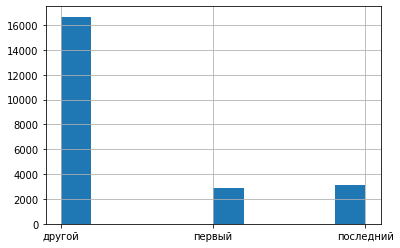

In [42]:
data['floor_type'].hist(bins=10)
plt.show()

Видим, что "первый" и "последний" этаж составляют практически одинаковое количество данных, большая часть это "другой" этаж.

Построим гистрограмму для количества этажей в доме.

In [43]:
data['floors_total'].describe()

count    22555.000000
mean        10.784748
std          6.636691
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

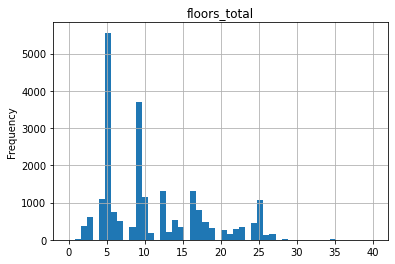

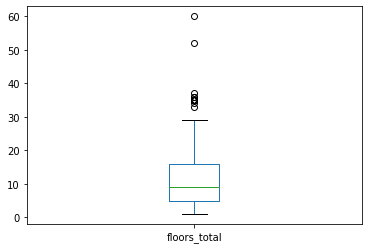

In [44]:
data['floors_total'].plot(kind='hist', bins=50, range=(0,40), grid=True, title='floors_total')
plt.show()
data['floors_total'].plot(kind='box')
plt.show()

Посчитаем процент выбросов и удалим их с датафрейма.

In [45]:
print(len(data.query('floors_total > 30')) / len(data))  

0.001413614878296594


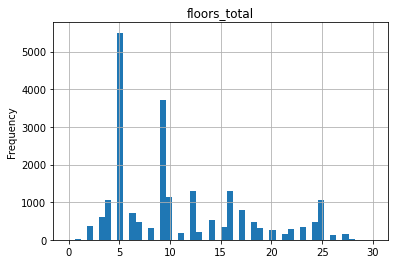

In [89]:
data = data.query('floors_total <= 30')
data['floors_total'].plot(kind='hist', bins=50, range=(0,30), grid=True, title='floors_total')
plt.show()

Построим гистрограмму по столбцу "расстояние до центра города в метрах"

In [47]:
data['city_centers_nearest'].describe()

count    17152.000000
mean     14573.030958
std       8520.949128
min        208.000000
25%       9975.750000
50%      13326.000000
75%      16482.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

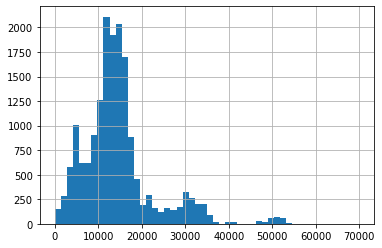

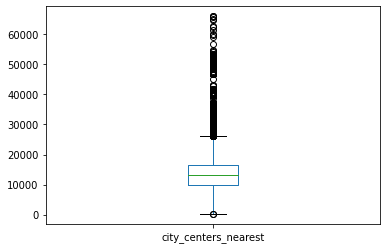

In [48]:
data['city_centers_nearest'].hist(bins=50, range=(0,70000))
plt.show()
data['city_centers_nearest'].plot(kind='box')
plt.show()

Удаляем данные выбросы из датафрейма.

In [49]:
#data = data.query('city_centers_nearest < 25000 and city_centers_nearest > 3000')

Аналогично сделаем анализ для столбца "расстояние до ближайшего парка".

In [50]:

data['parks_nearest'].describe()

count    7392.000000
mean      495.080087
std       344.926507
min         1.000000
25%       289.000000
50%       458.000000
75%       616.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22245 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22245 non-null  int64         
 1   last_price            22245 non-null  float64       
 2   total_area            22245 non-null  float64       
 3   first_day_exposition  22245 non-null  datetime64[ns]
 4   rooms                 22245 non-null  int64         
 5   ceiling_height        22245 non-null  float64       
 6   floors_total          22245 non-null  float64       
 7   living_area           22245 non-null  float64       
 8   floor                 22245 non-null  int64         
 9   is_apartment          22245 non-null  object        
 10  studio                22245 non-null  bool          
 11  open_plan             22245 non-null  bool          
 12  kitchen_area          22245 non-null  float64       
 13  balcony         

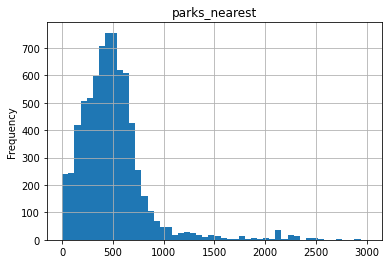

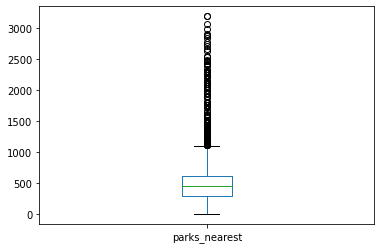

In [51]:
data['parks_nearest'].plot(kind='hist', bins=50, range=(0,3000), grid=True, title='parks_nearest')
plt.show()
data['parks_nearest'].plot(kind='box')
plt.show()

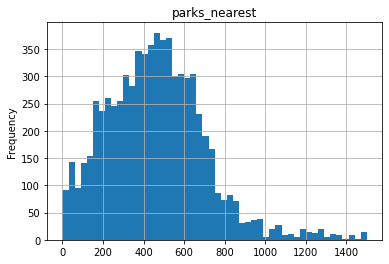

In [91]:
data['parks_nearest'].plot(kind='hist', bins=50, range=(0,1500), grid=True, title='parks_nearest')
plt.show()

2. Теперь проанализируем столбец "days_exposition" и посмотрим на гистрограмме как быстро продавались квартиры.

In [98]:
data = data.query('days_exposition > 0')
data['days_exposition'].describe()

count    19415.000000
mean       175.227711
std        213.350021
min          1.000000
25%         44.000000
50%         92.000000
75%        223.000000
max       1580.000000
Name: days_exposition, dtype: float64

По этим данным мы сразу можем сказать, что самая быстрая продажа была за 1 день, а самая длительная 1580 дней. Ну а в среднем объект продается за 175 дней (практически пол года).

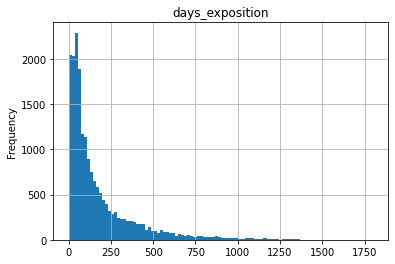

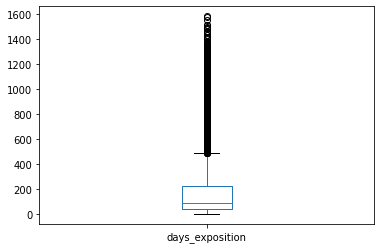

In [106]:
data['days_exposition'].plot(kind='hist', bins=100, range=(0,1800), grid=True, title='days_exposition')
plt.show()
data['days_exposition'].plot(kind='box')
plt.show()

In [101]:
print('Медианное значение равно:', data['days_exposition'].median())

Медианное значение равно: 92.0


In [114]:
print(data.query('days_exposition <= 30'))

       total_images  last_price  total_area first_day_exposition  rooms  \
11                9   3300000.0        44.0           2018-08-27      2   
15               16   4650000.0        39.0           2017-11-18      1   
34                3   3290000.0        33.0           2018-02-04      1   
39               15   5200000.0        54.4           2018-11-29      2   
53                7   4300000.0        39.1           2017-11-10      1   
...             ...         ...         ...                  ...    ...   
23671             3   3450000.0        35.3           2017-04-14      1   
23677             8   2450000.0        35.0           2018-10-26      1   
23688            19   9200000.0       101.0           2019-04-01      3   
23689            13   3550000.0        35.3           2018-02-28      1   
23690             3   5500000.0        52.0           2018-07-19      2   

       ceiling_height  floors_total  living_area  floor    is_apartment  \
11               2.65   

In [115]:
print(data.query('days_exposition >= 1000'))

       total_images  last_price  total_area first_day_exposition  rooms  \
109               2   7497600.0        62.5           2015-12-08      2   
353               4   5990000.0        43.5           2015-05-08      1   
398               7  12789000.0        79.3           2014-12-09      2   
437              12   3350000.0        37.0           2015-02-24      1   
459              13   5200000.0        51.0           2016-03-02      2   
...             ...         ...         ...                  ...    ...   
23318             6   5620020.0        82.3           2015-03-10      3   
23389             6   2850000.0        40.0           2015-01-26      1   
23426            17   8778000.0        47.5           2014-12-29      1   
23508             7   6100000.0        42.0           2015-02-19      1   
23540            10   1500000.0        43.7           2016-06-28      2   

       ceiling_height  floors_total  living_area  floor    is_apartment  \
109              2.65   

Мы ознакомились с данными, когда объекты были проданы менее чем за месяц и более чем 1000 дней. Можем сделать вывод, что длительнные продажи были связаны с экономическим и финансовым кризисом в РФ (2014-2016 гг.), так как данные объявления были размещены в этот промежуток времени. После стабилизации экономики (с 2016 года) спрос на недвижимость вырос, по этому и срок её покупки сократился.

3. Чтобы изучить как зависит цена от определенных параметров необходимо создать сводную таблицу, расспечатать матрицу корреляции и построить попарные диаграммы рассеяния.

              kitchen_area  last_price  living_area     rooms  total_area
kitchen_area      1.000000    0.488736     0.204065  0.107175    0.473353
last_price        0.488736    1.000000     0.520040  0.355021    0.661517
living_area       0.204065    0.520040     1.000000  0.886647    0.899911
rooms             0.107175    0.355021     0.886647  1.000000    0.788735
total_area        0.473353    0.661517     0.899911  0.788735    1.000000


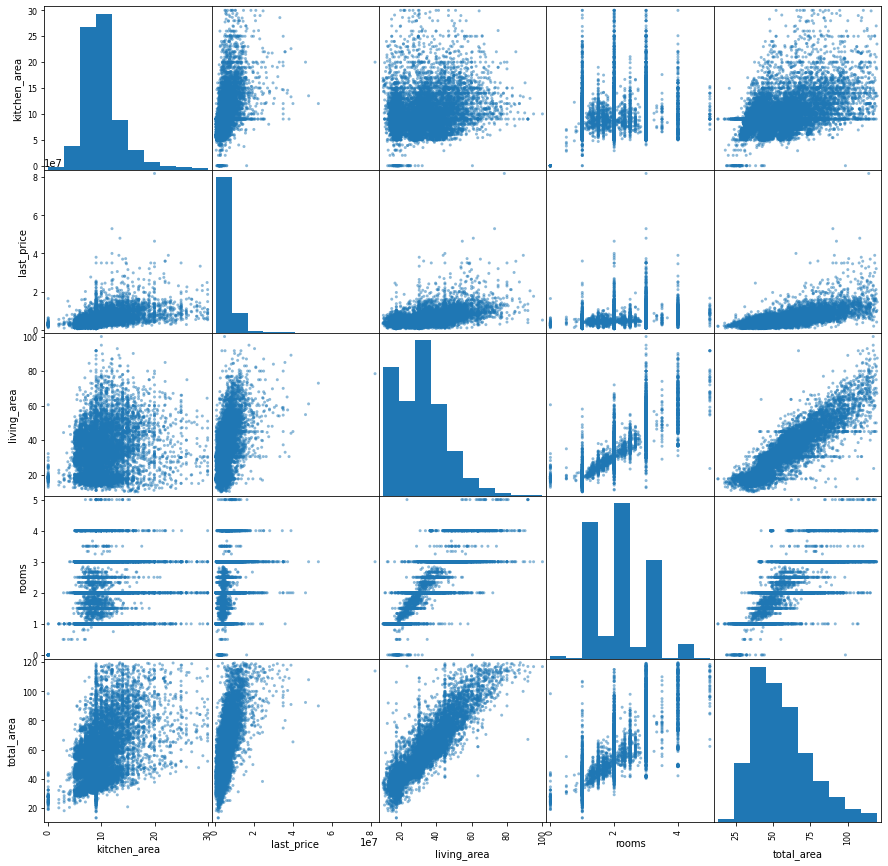

In [116]:
data_corr = (data
             .pivot_table(index='m2_price', values=['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type'], aggfunc='mean')
            )
print(data_corr.corr())
pd.plotting.scatter_matrix(data_corr, figsize=(15,15))
plt.show()

Из данных видно, что на цену больше всего влияет:
1. Общая площадь (коэф.корр.= 0.66)
2. Жилая площадь (коэф.корр.= 0.52)
3. Площадь кухни (коэф.корр.= 0.48)
4. Количетсво комнат (коэф.корр.= 0.35)


Из графика видно, что значительнных изменений в цене, от даты размещения,нет.

Отдельно построим график зависимости цены от этажа, так как "тип этажа" имеет тип данных 'object'.

0.08378764906076326


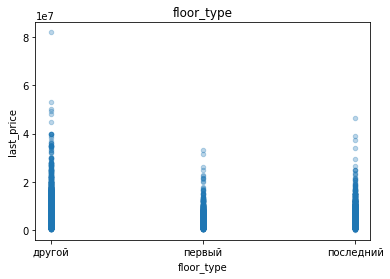

In [58]:
print(data['last_price'].corr(data['floor']))
data.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.3, title='floor_type')
plt.show()

Исходя из этого графика, цена практически не зависит от типа этажа.

4. Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [59]:
top_towns = (data
             .pivot_table(index='locality_name', values = 'm2_price', aggfunc=['count', 'mean'])
             .droplevel(level=1, axis=1)
            )
top_towns_sorted = top_towns.sort_values(by='count', ascending=False)
top_towns_sorted['mean'] = top_towns_sorted['mean'].apply(lambda x: '{:,.2f}'.format(x))
print(top_towns_sorted.head(10))

                   count        mean
locality_name                       
Санкт-Петербург    14736  110,991.11
посёлок Мурино       556   85,681.76
посёлок Шушары       439   78,666.17
Всеволожск           395   68,673.57
Пушкин               350  102,323.37
Колпино              336   75,370.03
посёлок Парголово    326   90,332.26
Гатчина              304   68,919.47
деревня Кудрово      299   92,473.55
Выборг               232   58,229.73


Согласно сводной таблице, можем сделать вывод, что самая высокая цена за м2 в городах: Санкт-Петербург (110 991) и Пушкин (102 323), самая низкая цена - Выборг (58 229), Всеволожск (68 673) и Гатчина (68 919).

5. Теперь узнаем как средняя цена зависит от рассположения объекта к центру города.

In [120]:
center = (data
          .query('locality_name == "Санкт-Петербург"')
          .pivot_table(index=['locality_name','city_centers_km'], values='m2_price', aggfunc='mean')
          .round()
          .reset_index()
         )
print(center)
print(center['city_centers_km'].corr(center['m2_price']))

      locality_name  city_centers_km  m2_price
0   Санкт-Петербург              0.0  169457.0
1   Санкт-Петербург              1.0  131326.0
2   Санкт-Петербург              2.0  135068.0
3   Санкт-Петербург              3.0  115374.0
4   Санкт-Петербург              4.0  126306.0
5   Санкт-Петербург              5.0  131659.0
6   Санкт-Петербург              6.0  131199.0
7   Санкт-Петербург              7.0  131696.0
8   Санкт-Петербург              8.0  119814.0
9   Санкт-Петербург              9.0  110092.0
10  Санкт-Петербург             10.0  110328.0
11  Санкт-Петербург             11.0  105281.0
12  Санкт-Петербург             12.0  105951.0
13  Санкт-Петербург             13.0  106248.0
14  Санкт-Петербург             14.0  102817.0
15  Санкт-Петербург             15.0  101824.0
16  Санкт-Петербург             16.0   98763.0
17  Санкт-Петербург             17.0   95567.0
18  Санкт-Петербург             18.0   95325.0
19  Санкт-Петербург             19.0   98053.0
20  Санкт-Пет

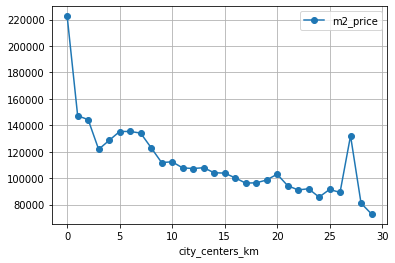

In [61]:
center.plot(x='city_centers_km', y='m2_price', style='o-', grid=True)
plt.show()

По графику мы видим отрицательную корреляцию: при росте величины "расстояние до центра города", стоимость квадратного метра уменьшается и наоборот, чем ближе объект находится к центру города - тем стоимость объекта больше.

### Общий вывод

#### Предобработка данных и их анализ
1. В ходе анализа архива данных о продаже квартир в Ленинградской области, были выявлены пропуска в следующих столбцах: высота потолков (38%), всего этажей в доме(менее 1%), жилая площадь(8%), апартаменты(88%), площадь кухни(9%), количество балконов(48%), наименование населённого пункта(менее 1), расстояние до центра города/аэропорта/водоёма (более 50%), срок размещения объявления(менее 1%). Большинство пропусков были заполненны медианным значением, столбец "балконы" - 0, аппартаменты - "No_information", название населенного пункта - "uknown", срок размещения объявления - на среднее значение. Пропуски в столбцах с 15-20 были оставлены как есть, так как их очень много и заполнять медианой и т.п. будет неверно.

2. Типы данных были приведены к соответствующему формату.

3. Аномальные значения в данных были скорректированы либо удалены.

4. Были построены графики и посчитаны коэфициенты корреляции, а также выполнен расчёт стоимости 1 м2.

#### Решение задачи

На основании анализа мы можем определять рыночную стоимость жилья по параметрам, которые напрямую влияют на него:
1. Общая площадь объекта, коэфициент корреляции 0.7
2. Жилая площадь, коэфициент корреляции 0.54
3. Площадь кухни, коэфициент корреляции 0.53
4. Количетсво комнат, коэфициент корреляции 0.36
5. Средняя стоимость за м2 в зависимости от населёного пункта.
6. Средняя стоимость за м2 в зависимости от рассположения к центру города, коэфициент корреляции -0.7

#### Рекомендации и наблюдения
1. В столбце 'apartment' слишком много пропусков, что не позволяет сделать анализ для расчета стоимости по типу жилья. Предлагаю сделать разработчикам форму, которая не будет принимать анкету если не заполнить все столбцы.
2. В наименовании населенных пунктов необходимо сделать выпадающий список при вводе информации, чтобы все значения были уникальными.
3. Также все значения, которые напрямую влияют на цену объекта (общая площадь, количество комнат и т.д.) не должны приниматься с пустыми значениями.
4. Я бы рекомендовала добавить параметр "Расстояние до ближайшего метро", так как такой показатель в городе Санкт-Петербург является важным и может повлиять на ценообразование.
5. Так как данные представлены нам за период c 2014 по 2019 год, при формирование стоимости объекта необходимо учитывать процент инфляции на текущую дату (в среднем стоимость за м2 увеличилась на 50 тыс.)
6. Необходимо дополнить данные годом постройки, так как более новые дома будут выше в цене.
7. Дата публикации объявления не влияет на ценообразование, а скорость продажи объекта зависит от экономичесткой составляющей страны.
